<a href="https://colab.research.google.com/github/pranjul6386/driver_distraction_states/blob/master/driver_states_distraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distracted-driver-detection/__results__.html
/kaggle/input/distracted-driver-detection/weights.h5
/kaggle/input/distracted-driver-detection/model.json
/kaggle/input/distracted-driver-detection/__notebook__.ipynb
/kaggle/input/distracted-driver-detection/custom.css
/kaggle/input/distracted-driver-detection/__output__.json


In [ ]:
from glob import glob
import random
import os
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

In [ ]:
dataset = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
dataset.head(5)


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
drivers = dataset.groupby('subject')
unique_drivers = drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [ ]:
def load_image(path, img_rows, img_cols, channels=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 

    return img

In [ ]:
num_classes=10
def load_train_images(img_rows,img_clos,channels):
    start_time=time.time()
    train_imgs=[]
    train_labels=[]
    for classes in tqdm(range(num_classes)):
        print("loading directory:c{}".format(classes))
        files = glob(os.path.join('..', 'input','state-farm-distracted-driver-detection','imgs','train', 'c' + str(classes), '*.jpg'))
        for file in files:
            img=load_image(file,img_rows,img_cols,channels)
            train_imgs.append(img)
            train_labels.append(classes)
        print("data loaded in {} seconds".format(time.time()-start_time))
    return train_imgs,train_labels

In [ ]:
def modified_data(img_rows, img_cols, channels):
    x,labels=load_train_images(img_rows,img_cols,channels=3)
    y=np_utils.to_categorical(labels,10)
    x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,channels)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,channels)
    
    return x_train, x_test, y_train, y_test

In [ ]:
../input/state-farm-distracted-driver-detection/imgs/test/img_100000.jpg

In [ ]:
def load_test_images(size=200000, img_rows=64, img_cols=64, channels=3):
    path = os.path.join('..', 'input','state-farm-distracted-driver-detection','imgs','test', '*.jpg')
    files = sorted(glob(path))
    X_test_images=[]
    X_test_id = []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = load_image(file, img_rows, img_cols, channels)
        X_test_images.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test_images, X_test_id

In [ ]:
def modified_test_images(size, img_rows, img_cols, channels=3):
    test_data, test_ids = load_test_images(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [ ]:
img_rows = 64
img_cols = 64
channels = 1

In [ ]:
x_train, x_test, y_train, y_test = modified_data(img_rows, img_cols, channels)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

loading directory:c0


 10%|█         | 1/10 [00:07<01:03,  7.03s/it]

data loaded in 7.027673006057739 seconds
loading directory:c1


 20%|██        | 2/10 [00:13<00:54,  6.84s/it]

data loaded in 13.436596393585205 seconds
loading directory:c2


 30%|███       | 3/10 [00:19<00:47,  6.74s/it]

data loaded in 19.9305202960968 seconds
loading directory:c3


 40%|████      | 4/10 [00:26<00:40,  6.71s/it]

data loaded in 26.568801164627075 seconds
loading directory:c4


 50%|█████     | 5/10 [00:33<00:33,  6.63s/it]

data loaded in 33.0053596496582 seconds
loading directory:c5


 60%|██████    | 6/10 [00:39<00:26,  6.66s/it]

data loaded in 39.73311710357666 seconds
loading directory:c6


 70%|███████   | 7/10 [00:46<00:19,  6.66s/it]

data loaded in 46.39340281486511 seconds
loading directory:c7


 80%|████████  | 8/10 [00:52<00:12,  6.36s/it]

data loaded in 52.06643271446228 seconds
loading directory:c8


 90%|█████████ | 9/10 [00:57<00:06,  6.07s/it]

data loaded in 57.438637256622314 seconds
loading directory:c9


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]

data loaded in 63.35046315193176 seconds
Train shape: (17939, 64, 64, 1)
17939 train samples


In [ ]:
nb_test_samples = 200
test_files, test_targets = modified_test_images(nb_test_samples, img_rows, img_cols, channels)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:01<06:43, 197.23it/s]


Test shape: (200, 64, 64, 1)
200 Test samples


In [ ]:
names = [item[17:19] for item in sorted(glob("../input/state-farm-distracted-driver-detection/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('..', 'input','state-farm-distracted-driver-detection','imgs','test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


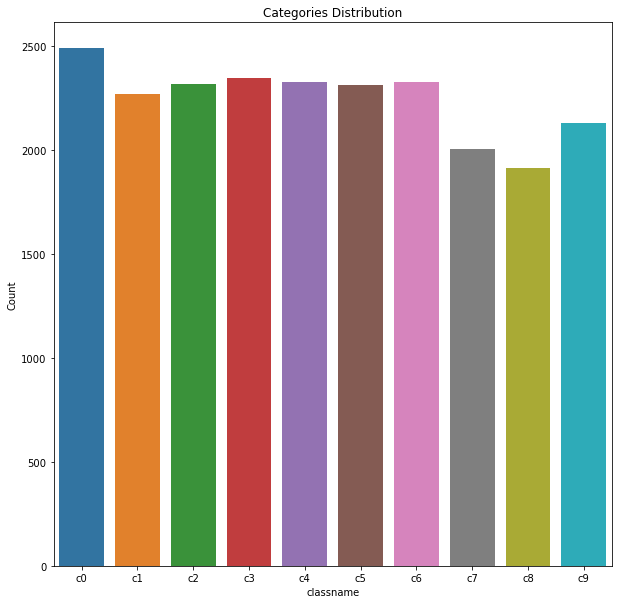

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(x = 'classname', data = dataset)
plt.ylabel('Count')
plt.title('Categories Distribution')

plt.show()

In [ ]:
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


In [ ]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

In [ ]:
batch_size = 40
nb_epoch = 10

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [ ]:
def create_model():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(64,(5,5),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model = create_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        1

In [ ]:
history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.5907
Epoch 00001: val_loss improved from inf to 1.00246, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 756s 2s/step - loss: 1.2659 - accuracy: 0.5907 - val_loss: 1.0025 - val_accuracy: 0.6963
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8815
Epoch 00002: val_loss improved from 1.00246 to 0.16261, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 757s 2s/step - loss: 0.3735 - accuracy: 0.8815 - val_loss: 0.1626 - val_accuracy: 0.9579
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9262
Epoch 00003: val_loss improved from 0.16261 to 0.10467, saving model to saved_models/weights_best_vanilla.hdf5
449/449 [==============================] - 759s 2s/step - loss: 0.2385 - accuracy: 0.9262 - val_loss: 0.1047 - val_accu

In [ ]:
model.load_weights('saved_models/weights_best_vanilla.hdf5')

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

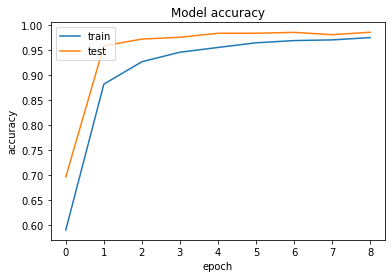

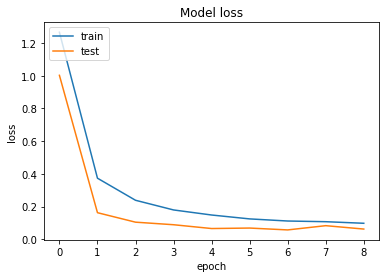

In [ ]:
plot_train_history(history)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)

141/141 [==============================] - 39s 277ms/step - loss: 0.0573 - accuracy: 0.9848
Score:  [0.05730505660176277, 0.9848383665084839]
113/113 [==============================] - 40s 353ms/step
Score log loss: 0.0573050652012514


In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(driver_activity.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

1/1 [==============================] - 0s 2ms/step
Y prediction: [[2.2058712e-15 1.7568137e-18 1.6266509e-14 5.0207208e-18 1.3479193e-13
  1.8054080e-14 1.2691437e-15 1.0000000e+00 1.4886827e-12 4.9727922e-14]]
Predicted: Reaching behind


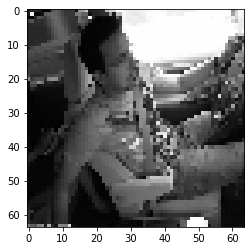

In [ ]:
plot_test_class(model, test_files, 101)

1/1 [==============================] - 0s 2ms/step
Y prediction: [[1.0267170e-09 1.3165032e-14 2.5944721e-10 4.9438820e-10 5.0629184e-10
  9.9999988e-01 1.2800631e-09 2.9806382e-09 1.9902080e-09 1.1163513e-07]]
Predicted: Operating the radio


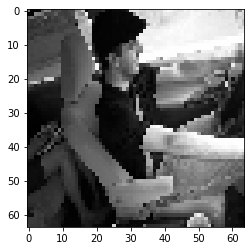

In [ ]:
plot_test_class(model, test_files, 1)

In [ ]:
plot_test_class(model, test_files, 133)

SyntaxError: unexpected EOF while parsing (<ipython-input-60-0e615193e9ed>, line 1)